# Drive Connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/mh analytics olympiad')

Mounted at /content/drive


# EDA

In [ ]:
import pandas as pd

train = pd.read_csv('train.csv')
train.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
0,FDU32,21.027499,Baking Goods,197.352319,OUT046,2004,Small,Tier 2,2689.457781
1,NCT54,21.102371,Meat,148.250214,OUT035,1987,Small,Tier 1,3437.350375
2,FDW08,20.882263,Hard Drinks,205.465010,OUT035,1999,Small,Tier 3,3129.967268
3,FDJ22,21.050435,Starchy Foods,253.417583,OUT046,1996,Small,Tier 1,1306.514376
4,FDF47,21.247876,Baking Goods,240.871039,OUT035,1988,Small,Tier 3,1739.769829


In [ ]:
train.shape

(87864, 9)

In [ ]:
for col in train:
  print(col, train[col].nunique(), '\n')

Item_ID 895 

Item_W 87283 

Item_Type 16 

Item_MRP 87814 

Outlet_ID 5 

Outlet_Year 12 

Outlet_Size 3 

Outlet_Location_Type 3 

Sales 87760 



In [ ]:
pd.DataFrame({
    'Outlet_ID Values': train['Outlet_ID'].value_counts().index,
    'Count': train['Outlet_ID'].value_counts().values
})

,Outlet_ID Values,Count
0,OUT035,24071
1,OUT046,20850
2,OUT018,17156
3,OUT049,13356
4,OUT013,12431


In [ ]:
pd.DataFrame({
    'Item_Type Values': train['Item_Type'].value_counts().index,
    'Count': train['Item_Type'].value_counts().values
})

,Item_Type Values,Count
0,Baking Goods,14666
1,Fruits and Vegetables,14328
2,Meat,8099
3,Snack Foods,7817
4,Household,6018
5,Soft Drinks,5396
6,Frozen Foods,5129
7,Canned,4565
8,Dairy,3807
9,Others,3688


In [ ]:
pd.DataFrame({
    'Outlet_Size Values': train['Outlet_Size'].value_counts().index,
    'Count': train['Outlet_Size'].value_counts().values
})

,Outlet_Size Values,Count
0,Small,48614
1,Medium,26683
2,High,12567


In [ ]:
pd.DataFrame({
    'Outlet_Location_Type Values': train['Outlet_Location_Type'].value_counts().index,
    'Count': train['Outlet_Location_Type'].value_counts().values
})


,Outlet_Location_Type Values,Count
0,Tier 1,33567
1,Tier 3,29044
2,Tier 2,25253


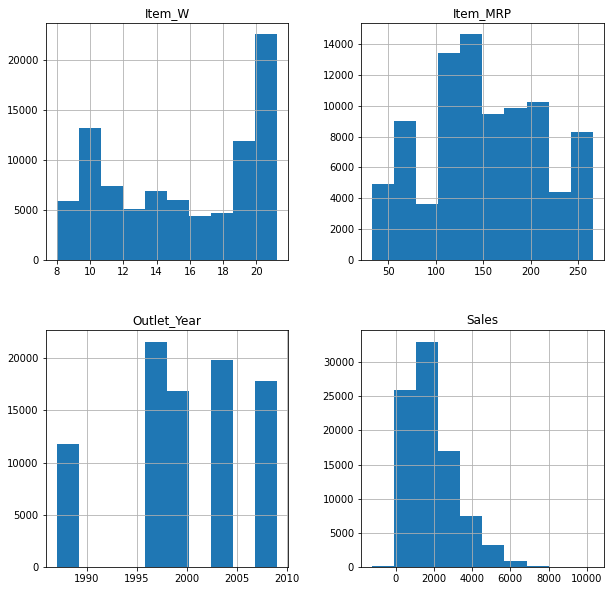

In [ ]:
import matplotlib.pyplot as plt

train.hist(figsize=(10,10))
#plt.savefig('dist.png', dpi=600, bbox_inches='tight')

In [ ]:
train.isnull().sum()

Item_ID                 0
Item_W                  0
Item_Type               0
Item_MRP                0
Outlet_ID               0
Outlet_Year             0
Outlet_Size             0
Outlet_Location_Type    0
Sales                   0
dtype: int64

In [ ]:
train.dtypes

Item_ID                  object
Item_W                  float64
Item_Type                object
Item_MRP                float64
Outlet_ID                object
Outlet_Year               int64
Outlet_Size              object
Outlet_Location_Type     object
Sales                   float64
dtype: object

# Preprocess Data

In [ ]:
numerical_cols = [
             'Item_MRP',
       'Outlet_Year' 
]

#'Item_W',

In [ ]:
categorical_cols = [
                    'Item_Type', 'Outlet_ID',
       'Outlet_Size', 'Outlet_Location_Type'
]
# 'Item_ID', 

In [ ]:
# no null values so no imputation required

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore'))
])

# define preprocessing steps

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Split Data

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)

In [ ]:
X = train[numerical_cols+categorical_cols]
Y = train['Sales']

# Build & Evaluate Model

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 23 kB/s 


In [ ]:
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', VotingRegressor(
                                  [
                                   ('cat', CatBoostRegressor(iterations=100, verbose=False)),
                                    ('xgb', XGBRegressor(objective ='reg:squarederror')),
                                    ('lgbm', LGBMRegressor())
                                   ],
                              ))
                             ])

In [ ]:
total = 0
i = 0
for train_idx, test_idx in kf.split(X):
  X_train, Y_train = X.iloc[train_idx], Y.iloc[train_idx]
  X_test, Y_test = X.iloc[test_idx], Y.iloc[test_idx]

  pipeline.fit(X_train, Y_train)
  y_pred = pipeline.predict(X_test)
  print("\n Fold " + str(i) + " RMSE: ", mean_squared_error(Y_test, y_pred, squared=False))
  total += mean_squared_error(Y_test, y_pred, squared=False)
  i += 1

print('\n Average RMSE: ', total/10)


 Fold 0 RMSE:  1278.275069011596

 Fold 1 RMSE:  1268.8580042059336

 Fold 2 RMSE:  1259.1690621977698

 Fold 3 RMSE:  1297.7764392728168

 Fold 4 RMSE:  1270.8664491155937

 Fold 5 RMSE:  1268.3107132353502

 Fold 6 RMSE:  1249.0513997980543

 Fold 7 RMSE:  1295.5000000533314

 Fold 8 RMSE:  1302.4432499457123

 Fold 9 RMSE:  1261.8838794345063

 Average RMSE:  1275.2134266270664


# Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(pipeline, X_test, Y_test,
                                random_state=0)

In [ ]:
pd.DataFrame({'cols': X.columns, "scores": result['importances_mean']})

,cols,scores
0,Item_MRP,0.002782
1,Outlet_Year,0.018811
2,Item_Type,0.005020
3,Outlet_ID,0.011064
4,Outlet_Size,0.004795
5,Outlet_Location_Type,0.002544


# Total Training RMSE

In [ ]:
pipeline.fit(X, Y)
y_pred = pipeline.predict(X)
print(mean_squared_error(Y, y_pred, squared=False))

1257.478223125429


# Predictions

In [ ]:
test = pd.read_csv('test.csv')
test.head()

,Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
0,DRM23,10.156725,Snack Foods,119.319482,OUT013,1999,High,Tier 3
1,FDG47,10.434425,Household,263.600449,OUT018,1987,High,Tier 3
2,FDN21,11.953589,Health and Hygiene,246.286990,OUT018,1997,High,Tier 1
3,FDZ23,14.948546,Dairy,136.200508,OUT046,2004,Medium,Tier 2
4,FDC16,11.080042,Canned,173.145664,OUT018,2009,Medium,Tier 3


In [ ]:
# store predictions as dataframe

submission = pd.DataFrame(pipeline.predict(test[categorical_cols+numerical_cols]))
submission.index = test.index
submission.columns = ['Sales']
#submission.head()

In [ ]:
submission.to_csv('submission.csv', index=False)

# Actual vs Predicted

In [ ]:
import matplotlib.pyplot as plt

y_pred = pipeline.predict(X)

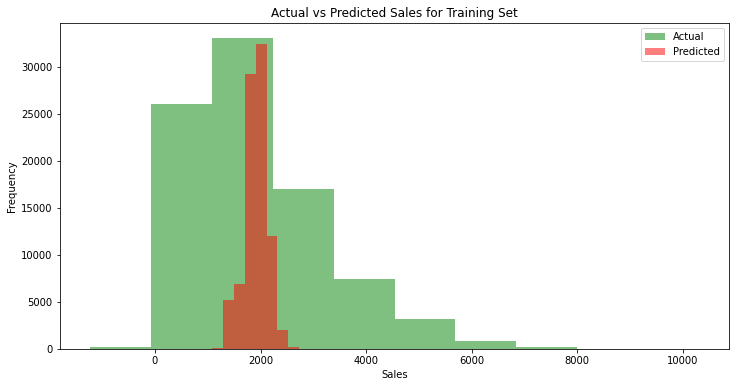

In [ ]:
plt.rcParams['figure.figsize'] = (12,6)
plt.hist(Y, alpha=0.5, color='green', label='Actual')
plt.hist(y_pred, alpha=0.5, color='red', label='Predicted')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Actual vs Predicted Sales for Training Set')
plt.legend()
#plt.savefig('act_vs_pred.png', dpi=600, bbox_inches='tight')

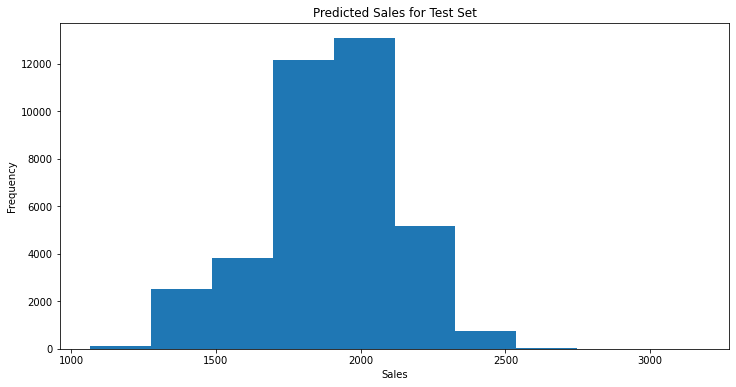

In [ ]:
plt.hist(submission['Sales'])
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Predicted Sales for Test Set')

#plt.savefig('test.png', dpi=600, bbox_inches='tight')